c:\Users\刘路泽\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\刘路泽\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/35 | Train Loss: 1.3810 Acc: 0.5580 | Val Loss: 0.8247 Acc: 0.7404
Epoch 2/35 | Train Loss: 0.9452 Acc: 0.7018 | Val Loss: 0.6337 Acc: 0.8104
Epoch 3/35 | Train Loss: 0.8099 Acc: 0.7460 | Val Loss: 0.6121 Acc: 0.8071
Epoch 4/35 | Train Loss: 0.7272 Acc: 0.7677 | Val Loss: 0.5216 Acc: 0.8417
Epoch 5/35 | Train Loss: 0.6896 Acc: 0.7832 | Val Loss: 0.4199 Acc: 0.8729
Epoch 6/35 | Train Loss: 0.6135 Acc: 0.8045 | Val Loss: 0.4194 Acc: 0.8762
Epoch 7/35 | Train Loss: 0.5978 Acc: 0.8146 | Val Loss: 0.4181 Acc: 0.8717
Epoch 8/35 | Train Loss: 0.5706 Acc: 0.8187 | Val Loss: 0.3909 Acc: 0.8733
Epoch 9/35 | Train Loss: 0.5324 Acc: 0.8297 | Val Loss: 0.3216 Acc: 0.9021
Epoch 10/35 | Train Loss: 0.5180 Acc: 0.8396 | Val Loss: 0.3232 Acc: 0.9012
Epoch 11/35 | Train Loss: 0.4878 Acc: 0.8469 | Val Loss: 0.2979 Acc: 0.9117
Epoch 12/35 | Train Loss: 0.4833 Acc: 0.8464 | Val Loss: 0.3081 Acc: 0.9046
Epoch 13/35 | Train Loss: 0.4639 Acc: 0.8554 | Val Loss: 0.3065 Acc: 0.9129
Epoch 14/35 | Train L

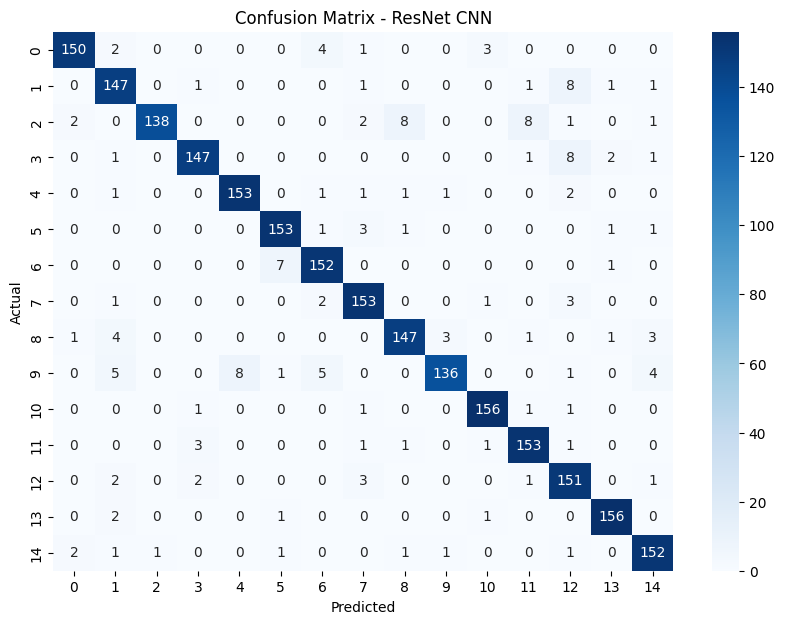

model saved


In [1]:
import os
import cv2
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision import transforms

# first we need get the class name from dataset
# use os to manipulate it 
def get_classes(data_dir):
    # the data_dir is train/ 
    ans = []
    for d in os.listdir(data_dir):
        # d is the class label, use join to entry the folder
        if os.path.isdir(os.path.join(data_dir, d)):
            ans.append(d)
    return sorted(ans)

# DATA AUGMENTATION      
def transform(input_size = 224):
    train_transform = transforms.Compose([
        #transforms.ToPILImage(),    # convert input to PIL image
        transforms.RandomResizedCrop(input_size),    # stochastic crop image
        transforms.RandomHorizontalFlip(),  # random horizontal flip the image
        transforms.RandomRotation(15),  # random rotation 15 degree
        transforms.ToTensor(),  # put it to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    test_transform = transforms.Compose([
       # transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return train_transform, test_transform

class ImageDataset(Dataset):
    def __init__(self, image_path, class_name, transform = None):
        # initial parameter
        # in imagedataset we need get the class name, where find image and transform image to digital 
        self.image_path = image_path    # each image path
        self.class_name = class_name    # image class name    
        self.transform = transform
        
    def __len__(self):
        # in torch dataset we need save the number of samples
        return len(self.image_path)
    
    def __getitem__(self, index):
        # each image path
        img_path = self.image_path[index]
        image = Image.open(img_path).convert('RGB')
        # basename will gets the name of that folder and dirname gets the folder that contains the image
        # one is folder and other is get the name
        label_name = os.path.basename(os.path.dirname(img_path))
        label = self.class_name.index(label_name)
        if self.transform:
            image = self.transform(image)
        return image, label
    

    
def get_dataloader(data_dir, transform):
    # get the picture class from the dir this step is to separate and summary
    classes = get_classes(data_dir)
    """
    # get the path of each picture
    # gothrough every directory in train, x is the class name x[0] is current directory path
    # glob will get all .jpg in that directory
    # y is picture from that directory, loop to get all of them
    image_paths = [y for x in os.walk(data_dir) for y in glob(os.path.join(x[0], '*.jpg'))]
    # WE NEED SEPATRATE train data to train and validation to test overfitting
    train_paths, val_paths = train_test_split(image_paths, test_size=test_split, random_state=2)
    # transform picture to tensor
    # add data augmentation
    """
    image_path = [y for x in os.walk(data_dir) for y in glob(os.path.join(x[0], '*.jpg'))]
    data = ImageDataset(image_path, classes, transform)
    
    
    return data, classes
    

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# classcial CNN model design
class CONV(nn.Module):
    # inherited nn model from torch
    def __init__(self, input_channels, num_classes):
        super().__init__()
        # set the CONV layers
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        # set the pooling to reduce half, select max pooling
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv2D(32)
        x = self.pool(F.relu(self.conv2(x)))  # Conv2D(64)
        x = self.pool(F.relu(self.conv3(x)))  # Conv2D(128)
        x = self.pool(F.relu(self.conv4(x)))  # Conv2D(128)
        x = x.view(x.size(0), -1)             # Flatten
        x = self.dropout(F.relu(self.fc1(x)))              # Dense(512)
        x = self.fc2(x)                       # Dense(class_indices)
        return x          # Softmax output
    
class CONV_ResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # use pretrain model
        self.model = models.resnet18(pretrained = True)
        
        # replace final layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.model(x)

import torch
import os
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from CNN_model import CONV_ResNet
from CNN_image_process import get_dataloader, transform
from evaluate import evaluate_model

def train_one_epoch(model, dataloader, optimizer, loss_func, device):
    model.train()
    total_loss, correct = 0, 0
    for image, label in dataloader:
        # take image and label form dataloader and put them to GPU
        image = image.to(device)
        label = label.to(device)
        
        output = model(image)
        loss = loss_func(output, label)
        
        # set optimal
        # change gradient during training time
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * image.size(0)
        # correct will sum all dimention = 1
        correct += (output.argmax(1) == label).sum().item()
    
    #return the acc and loss
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)


# validation function to test overfitting 
def validation(model, dataloader, loss_func, device):
    model.eval()
    total_loss, correct = 0, 0
    all_preds = []
    all_class = []
    with torch.no_grad():
        for image, label in dataloader:
            image = image.to(device)
            label = label.to(device)
            
            output = model(image)
            preds = output.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_class.extend(label.cpu().numpy())
            loss = loss_func(output, label)
            
            total_loss += loss.item() * image.size(0)
            correct += (preds == label).sum().item()
            
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset), all_preds, all_class

if __name__ == "__main__":
    # base value
    trainData_path = os.path.join("dataset", "train")
    testData_path = os.path.join("dataset", "test")
    save_path = os.path.join("net", "CNN_RESULT.pth")
    batch_size = 10
    image_size = 224
    epochs = 35
    lr = 0.001
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # data process
    tran_transform, test_transform = transform(input_size= 224)
    train_data, classes = get_dataloader(trainData_path, transform= tran_transform)
    test_data, classes = get_dataloader(testData_path, transform= test_transform)
    
    # dataloader
    train_loader = DataLoader(train_data, batch_size = len(classes), shuffle = True)
    val_loader = DataLoader(test_data, batch_size = len(classes), shuffle = False)
    model = CONV_ResNet(num_classes= len(classes)).to(device)
    
    loss_func = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    
    #set epoch
    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader,optimizer, loss_func, device)
        val_loss, val_acc,_,_ = validation(model,val_loader, loss_func, device)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    _, _, preds, label = validation(model,val_loader, loss_func, device)
    evaluate_model(label, preds, "ResNet CNN")
    torch.save(model.state_dict(), save_path)
    print("model saved")
        
             
    